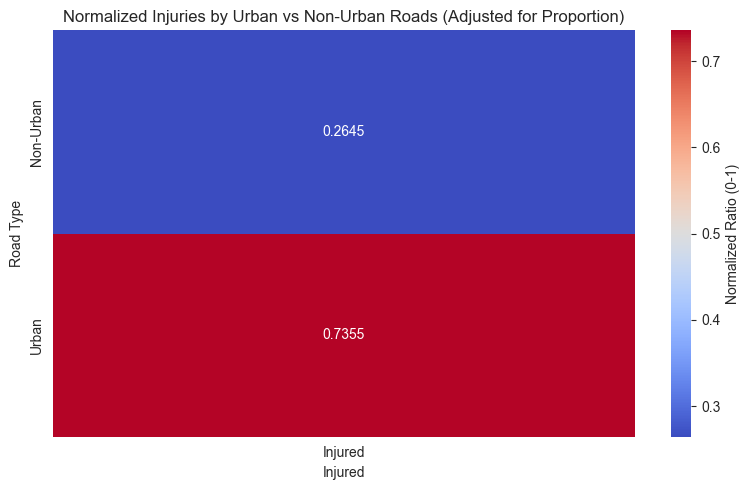

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data extracted from the heatmap
data = {
    "Fatal": [135, 754, 236, 422],
    "Severe Injury": [836, 2745, 2139, 4787],
    "Minor Injury": [5457, 8303, 17018, 15228]
}
road_types = ["Non-Urban Junction", "Non-Urban Road", "Urban Junction", "Urban Road"]

# Create a DataFrame
df = pd.DataFrame(data, index=road_types)

# Aggregate Urban and Non-Urban rows
df_binary = pd.DataFrame({
    "Fatal": [df.loc[["Non-Urban Junction", "Non-Urban Road"]].sum().values[0],
              df.loc[["Urban Junction", "Urban Road"]].sum().values[0]],
    "Severe Injury": [df.loc[["Non-Urban Junction", "Non-Urban Road"]].sum().values[1],
                      df.loc[["Urban Junction", "Urban Road"]].sum().values[1]],
    "Minor Injury": [df.loc[["Non-Urban Junction", "Non-Urban Road"]].sum().values[2],
                     df.loc[["Urban Junction", "Urban Road"]].sum().values[2]]
}, index=["Non-Urban", "Urban"])

# Adjust for urban road proportions (56% urban, 44% non-urban)
road_distribution = {"Non-Urban": 0.44, "Urban": 0.56}
weights = np.array([road_distribution["Non-Urban"], road_distribution["Urban"]])
df_weighted = df_binary.mul(weights, axis=0)

# Sum the severities into a single column called 'Injured'
df_weighted["Injured"] = df_weighted.sum(axis=1)

# Normalize for table-wise ratios
df_ratios_weighted = df_weighted[["Injured"]] / df_weighted["Injured"].sum()

# Plot the weighted table with a single column
plt.figure(figsize=(8, 5))
sns.heatmap(df_ratios_weighted, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Normalized Ratio (0-1)'})
plt.title("Normalized Injuries by Urban vs Non-Urban Roads (Adjusted for Proportion)")
plt.xlabel("Injured")
plt.ylabel("Road Type")
plt.tight_layout()
plt.show()


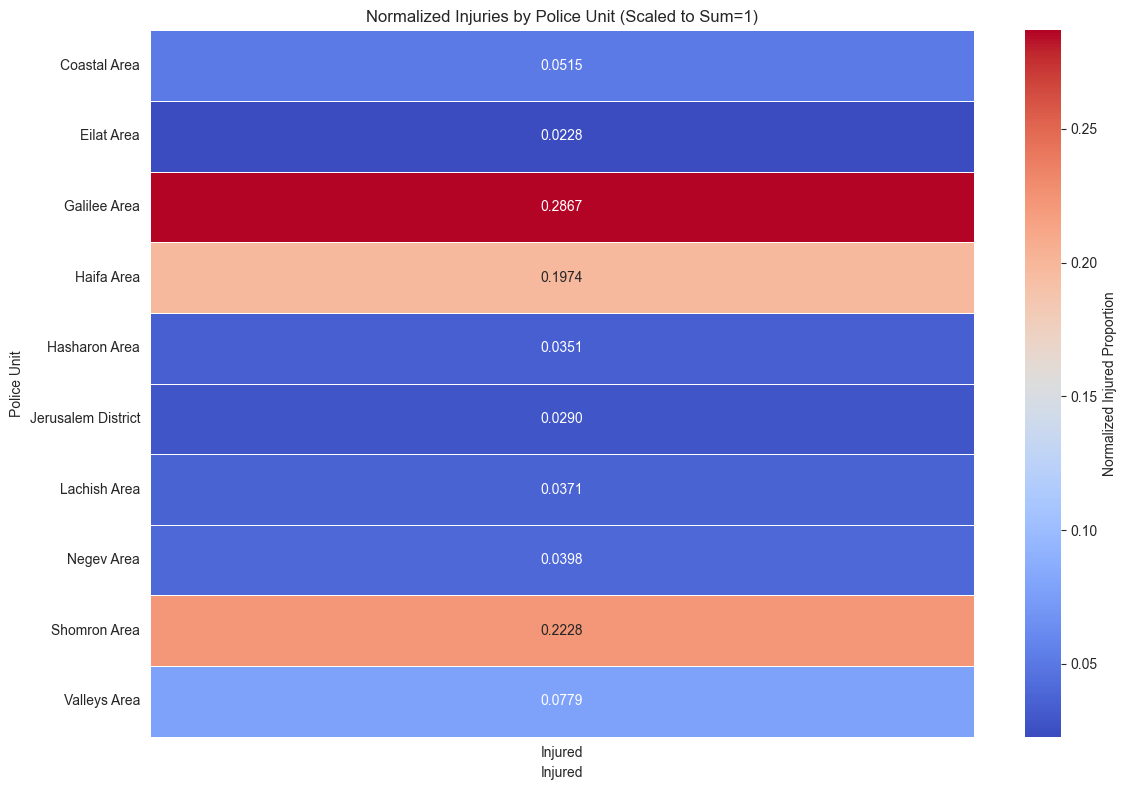

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = './Datasets/annual_drive_km_per_city.csv'

# Load and clean the dataset
city_data_cleaned = pd.read_csv(
    file_path,
    skiprows=14,  # Start at the row where actual data begins (Umm Al-Fahm onward)
    names=["City", "Annual_Kilometers_Travelled", "Licenced_to_Drive",
           "Privately_Owned_Vehicles", "Population", "Notes1", "Notes2"],
    usecols=["City", "Annual_Kilometers_Travelled", "Privately_Owned_Vehicles", "Population"]
)

# Drop any rows with NaN values in essential columns
city_data_cleaned = city_data_cleaned.dropna(subset=["City", "Annual_Kilometers_Travelled",
                                                     "Privately_Owned_Vehicles", "Population"])

# Convert numeric columns from strings to proper numeric types
city_data_cleaned["Annual_Kilometers_Travelled"] = pd.to_numeric(
    city_data_cleaned["Annual_Kilometers_Travelled"].str.replace(",", "", regex=False), errors="coerce"
)
city_data_cleaned["Privately_Owned_Vehicles"] = pd.to_numeric(
    city_data_cleaned["Privately_Owned_Vehicles"].str.replace(",", "", regex=False), errors="coerce"
)
city_data_cleaned["Population"] = pd.to_numeric(
    city_data_cleaned["Population"].str.replace(",", "", regex=False), errors="coerce"
)

# Calculate kilometers driven per city
city_data_cleaned["Population_Calculated"] = city_data_cleaned["Population"] * 1000
city_data_cleaned["Vehicle_Ratio"] = city_data_cleaned["Privately_Owned_Vehicles"] / 1000
city_data_cleaned["Annual_Kilometers_Travelled_Calculated"] = city_data_cleaned["Annual_Kilometers_Travelled"] * 1000
city_data_cleaned["Kilometers_Driven"] = (
    city_data_cleaned["Population_Calculated"] * city_data_cleaned["Vehicle_Ratio"] * city_data_cleaned["Annual_Kilometers_Travelled_Calculated"]
)

# Map cities to police units
city_to_police_unit = {
    "Umm Al-Fahm": "Valleys Area",
    "Ofaqim": "Negev Area",
    "Or Yehuda": "Hasharon Area",
    "Or Aqiva": "Coastal Area",
    "Elat": "Eilat Area",
    "Elad": "Hasharon Area",
    "Ari'el": "Shomron Area",
    "Ashdod": "Lachish Area",
    "Ashqelon": "Lachish Area",
    "Baqa Al-Gharbiyya": "Valleys Area",
    "Be'er Sheva": "Negev Area",
    "Bet She'an": "Valleys Area",
    "Bet Shemesh": "Jerusalem District",
    "Betar Illit": "Jerusalem District",
    "Bene Beraq": "Hasharon Area",
    "Bat Yam": "Hasharon Area",
    "Giv'at Shemuel": "Hasharon Area",
    "Giv'atayim": "Hasharon Area",
    "Dimona": "Negev Area",
    "Hod HaSharon": "Hasharon Area",
    "Herzliyya": "Hasharon Area",
    "Hadera": "Coastal Area",
    "Holon": "Hasharon Area",
    "Haifa": "Haifa Area",
    "Tiberias": "Galilee Area",
    "Tayibe": "Coastal Area",
    "Tire": "Coastal Area",
    "Tirat Karmel": "Haifa Area",
    "Tamra": "Galilee Area",
    "Yavne": "Lachish Area",
    "Yehud": "Hasharon Area",
    "Yoqne'am Illit": "Haifa Area",
    "Jerusalem": "Jerusalem District",
    "Kefar Yona": "Hasharon Area",
    "Kefar Sava": "Hasharon Area",
    "Kafar Qasem": "Hasharon Area",
    "Karmi'el": "Galilee Area",
    "Lod": "Coastal Area",
    "Migdal HaEmeq": "Galilee Area",
}

# Add police unit information to the DataFrame
city_data_cleaned["Police Unit"] = city_data_cleaned["City"].map(city_to_police_unit)

# Calculate total kilometers driven per police unit
police_unit_km = city_data_cleaned.groupby("Police Unit")["Kilometers_Driven"].sum().reset_index()
police_unit_km.rename(columns={"Kilometers_Driven": "Total_Kilometers_Driven"}, inplace=True)

# Accident severity data
severity_data = {
    "Police Unit": [
        "Coastal Area", "Eilat Area", "Galilee Area", "Haifa Area", "Hasharon Area",
        "Jerusalem District", "Lachish Area", "Negev Area", "Shomron Area", "Valleys Area"
    ],
    "Fatal": [59, 12, 289, 220, 170, 121, 110, 201, 69, 88],
    "Severe Injury": [612, 57, 1796, 2230, 1190, 1164, 634, 824, 185, 498],
    "Minor Injury": [3150, 238, 9140, 12071, 5789, 4297, 2622, 1847, 833, 2010]
}
severity_df = pd.DataFrame(severity_data)

# Merge severity data with total kilometers driven
severity_with_km = severity_df.merge(police_unit_km, on="Police Unit")

# Normalize accidents by total kilometers driven (per 100 km) and sum up severities
severity_with_km["Injured"] = (
    (severity_with_km["Fatal"] + severity_with_km["Severe Injury"] + severity_with_km["Minor Injury"]) /
    severity_with_km["Total_Kilometers_Driven"]
) * 100000

# Drop unneeded columns and keep only the Police Unit and Injured column
severity_with_km = severity_with_km[["Police Unit", "Injured"]]

# Normalize the Injured column so the sum equals 1
severity_with_km["Injured"] = severity_with_km["Injured"] / severity_with_km["Injured"].sum()

# Set Police Unit as the index for heatmap visualization
severity_with_km.set_index("Police Unit", inplace=True)

# Create a heatmap for normalized injuries
plt.figure(figsize=(12, 8))
sns.heatmap(
    severity_with_km,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".4f",
    cbar_kws={"label": "Normalized Injured Proportion"}
)
plt.title("Normalized Injuries by Police Unit (Scaled to Sum=1)")
plt.xlabel("Injured")
plt.ylabel("Police Unit")
plt.tight_layout()
plt.show()



This dataset represents the normalized probability of being involved in a fatal crash on highways in the US,
segmented by age groups and gender (male and female). The probabilities are normalized to provide
relative comparisons across demographics. This version adjusts for the average annual kilometers driven
by each age group, providing a more accurate representation of relative risk per kilometer driven.



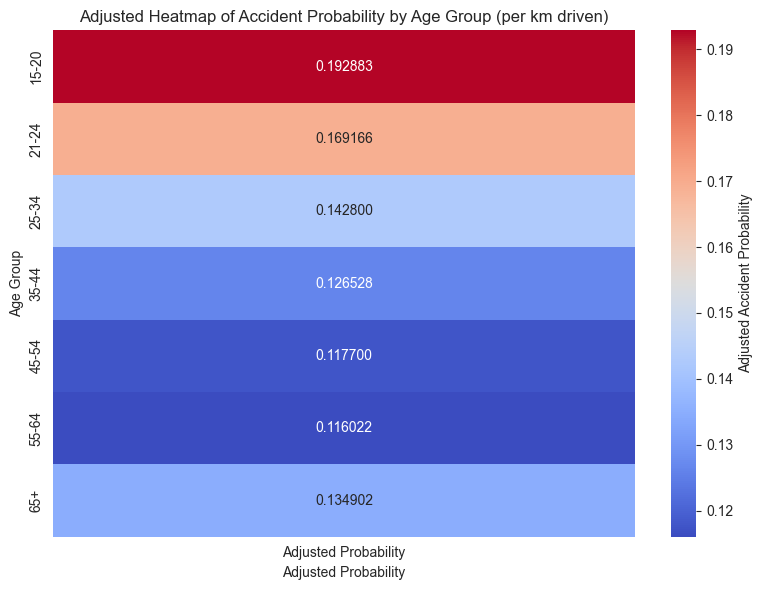

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

description = """
This dataset represents the normalized probability of being involved in a fatal crash on highways in the US,
segmented by age groups and gender (male and female). The probabilities are normalized to provide
relative comparisons across demographics. This version adjusts for the average annual kilometers driven
by each age group, providing a more accurate representation of relative risk per kilometer driven.
"""

# Print the description
print(description)

# Data from the provided table
data = {
    "Age Group": ["15-20", "21-24", "25-34", "35-44", "45-54", "55-64", "65+"],
    "Normalized Male Rate": [0.188378632, 0.172758513, 0.1495314, 0.120899719, 0.113098659, 0.099653537, 0.080912215],
    "Normalized Female Rate": [0.222513089, 0.187609075, 0.145724258, 0.116928447, 0.093386237, 0.082079232, 0.088132635],
}

# Annual kilometers driven by age group
annual_kilometers = {
    "15-20": 17000,
    "21-24": 17000,
    "25-34": 16500,
    "35-44": 15000,
    "45-54": 14000,
    "55-64": 12500,
    "65+": 10000,
}

# Convert data into a pandas DataFrame
df = pd.DataFrame(data)

# Sum up the probabilities for male and female to create a single column
df["Accident Probability"] = df["Normalized Male Rate"] + df["Normalized Female Rate"]

# Adjust probabilities by annual kilometers driven
df["Adjusted Probability"] = df.apply(
    lambda row: row["Accident Probability"] / annual_kilometers[row["Age Group"]], axis=1
)

# Normalize the adjusted probabilities so the total sums to 1
df["Adjusted Probability"] = df["Adjusted Probability"] / df["Adjusted Probability"].sum()

# Create a DataFrame for the heatmap
heatmap_data = df[["Age Group", "Adjusted Probability"]].set_index("Age Group")

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".6f", cmap="coolwarm", cbar_kws={"label": "Adjusted Accident Probability"})
plt.title("Adjusted Heatmap of Accident Probability by Age Group (per km driven)")
plt.xlabel("Adjusted Probability")
plt.ylabel("Age Group")
plt.tight_layout()

# Show the plot
plt.show()


Normalized Total Accidents by Hour:
00-01: 0.0950
01-02: 0.1154
02-03: 0.1248
03-04: 0.1047
04-05: 0.0564
05-06: 0.0275
06-07: 0.0177
07-08: 0.0152
08-09: 0.0139
09-10: 0.0142
10-11: 0.0144
11-12: 0.0164
12-13: 0.0185
13-14: 0.0183
14-15: 0.0201
15-16: 0.0208
16-17: 0.0212
17-18: 0.0217
18-19: 0.0224
19-20: 0.0256
20-21: 0.0324
21-22: 0.0387
22-23: 0.0542
23-24: 0.0906


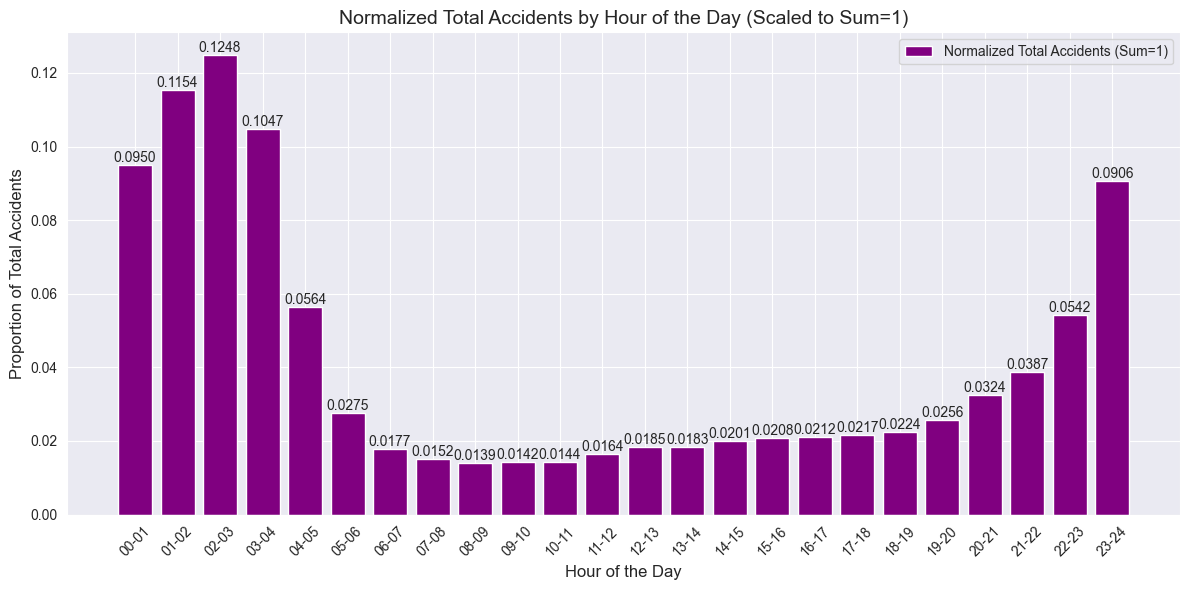

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with actual data)
hours = [f"{i:02d}-{i+1:02d}" for i in range(24)]  # Hours of the day
severe_accidents = np.array([54, 40, 29, 25, 26, 38, 61, 105, 111, 106, 107, 121, 136, 136, 148, 153, 155, 158, 152, 145, 129, 110, 93, 83])
fatal_accidents = np.array([5, 3, 2, 1, 2, 3, 5, 8, 10, 9, 9, 11, 13, 12, 14, 15, 16, 17, 15, 14, 12, 10, 8, 7])

# Traffic volume as percentage (convert to fraction)
traffic_volume = np.array([0.005, 0.003, 0.002, 0.002, 0.004, 0.012, 0.03, 0.06, 0.07, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.06, 0.05, 0.035, 0.025, 0.015, 0.008])

# Sum accidents and normalize by traffic volume
total_accidents = severe_accidents + fatal_accidents
normalized_accidents = total_accidents / traffic_volume

# Scale normalized data so the sum of all bars equals 1
normalized_scaled = normalized_accidents / normalized_accidents.sum()

# Print the normalized values
print("Normalized Total Accidents by Hour:")
for hour, value in zip(hours, normalized_scaled):
    print(f"{hour}: {value:.4f}")

# Plotting the normalized graph
plt.figure(figsize=(12, 6))
x = np.arange(len(hours))

bars = plt.bar(x, normalized_scaled, color='purple', label='Normalized Total Accidents (Sum=1)')

# Add the values on top of each bar
for bar, value in zip(bars, normalized_scaled):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.4f}", ha='center', va='bottom', fontsize=10)

plt.title("Normalized Total Accidents by Hour of the Day (Scaled to Sum=1)", fontsize=14)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Proportion of Total Accidents", fontsize=12)
plt.xticks(x, hours, rotation=45, fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import pandas as pd

# Set parameters
num_samples = 100000
accident_probability = 0.0007904958704959287

# Probabilities for features
road_type_probs = [0.2645, 0.7355]  # Non-Urban, Urban
police_unit_probs = [0.2059, 0.1998, 0.0422, 0.0565, 0.0893, 0.0772, 0.0787, 0.0598, 0.1052, 0.0853]
age_group_probs = [0.1929, 0.1692, 0.1428, 0.1265, 0.1177, 0.1160, 0.1349]  # 15-20, 21-24, ..., 65+
hour_probs = [0.0950, 0.1154, 0.1248, 0.1047, 0.0563, 0.0563, 0.0563, 0.0563,
              0.0563, 0.0563, 0.0563, 0.0563, 0.0563, 0.0563, 0.0600, 0.0500,
              0.0350, 0.0250, 0.0150, 0.0080, 0.0076, 0.0076, 0.0076, 0.0076]

# Normalize probabilities to ensure they sum to 1
police_unit_probs = np.array(police_unit_probs) / sum(police_unit_probs)
age_group_probs = np.array(age_group_probs) / sum(age_group_probs)
hour_probs = np.array(hour_probs) / sum(hour_probs)

# Define feature values
road_types = ["Non-Urban", "Urban"]
police_units = [
    "Galilee Area", "Haifa Area", "Eilat Area", "Negev Area", "Valleys Area",
    "Jerusalem District", "Lachish Area", "Hasharon Area", "Coastal Area", "Shomron Area"
]
age_groups = ["15-20", "21-24", "25-34", "35-44", "45-54", "55-64", "65+"]
hours = [f"{i:02d}:00" for i in range(24)]

# Generate features independently
np.random.seed(42)  # For reproducibility
road_type_samples = np.random.choice(road_types, size=num_samples, p=road_type_probs)
police_unit_samples = np.random.choice(police_units, size=num_samples, p=police_unit_probs)
age_group_samples = np.random.choice(age_groups, size=num_samples, p=age_group_probs)
hour_samples = np.random.choice(hours, size=num_samples, p=hour_probs)

# Determine if an accident occurred based on the given probability
accident_samples = np.random.choice([0, 1], size=num_samples, p=[1 - accident_probability, accident_probability])

# Create a DataFrame
dataset = pd.DataFrame({
    "Hour": hour_samples,
    "Police Unit": police_unit_samples,
    "Age Group": age_group_samples,
    "Road Type": road_type_samples,
    "Accident": accident_samples
})

# Display a preview of the dataset
# Save the dataset to a CSV file
output_file_path = '/Users/yotamtsabari/Desktop/simulated_trip_dataset.csv'
dataset.to_csv(output_file_path, index=False)

output_file_path



'/Users/yotamtsabari/Desktop/simulated_trip_dataset.csv'